<a href="https://colab.research.google.com/github/niikun/ai_engineering_day3/blob/main/RAG_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Agent
- tool としてRAG、Web検索もツールに持つ  
- Langgraphで実装

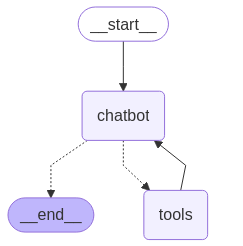

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_openai langchain-community langchain-chroma

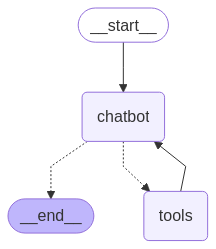

In [ ]:
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
# 演習用のコンテンツを取得
!git clone https://github.com/matsuolab/lecture-ai-engineering.git

Cloning into 'lecture-ai-engineering'...
remote: Enumerating objects: 52, done.
remote: Total 52 (delta 0), reused 0 (delta 0), pack-reused 52 (from 1)
Receiving objects: 100% (52/52), 83.21 KiB | 372.00 KiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
question = "LLMにおけるInference Time Scalingとは？"
gold_answer = "「Inference Time Scaling」とは、推論時に計算量を増やしてモデルの性能を高める手法です。これはモデルのサイズを大きくする代わりに、難しい入力に対して多くの計算リソースを使うことで、より良い出力を得ようとするアプローチです。"

In [ ]:
import os
import json
from typing import Annotated
from google.colab import userdata
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.tools import BaseTool
from typing import Type,Any,List
from langchain.schema import BaseRetriever,Document, AIMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import ToolMessage
from langgraph.checkpoint.memory import MemorySaver

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["LANGSMITH_API_KEY"] = userdata.get('lang_smith')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
%env LANGCHAIN_TRACING_V2=true
%env LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
%env LANGSMITH_PROJECT="RAG-Agent"

model = ChatOpenAI(model_name="gpt-4o-mini")

# テキストローダーの準備
loader = TextLoader("/content/lecture-ai-engineering/day3/data/LLM2024_day4.txt")
docs = loader.load()

# テキストのチャンク分け
text_splitter = CharacterTextSplitter(
    chunk_size=1000,chunk_overlap=200
)
all_splits = text_splitter.split_documents(docs)

# チャンクの埋め込み準備
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

db = Chroma.from_documents(all_splits,embeddings)
retriever = db.as_retriever()

# promptの生成
prompt = ChatPromptTemplate.from_template("""
以下の文脈をもとに質問に回答してください。
'''
文脈：
{context}
'''

質問：{question}
""")

class RAGTool(BaseTool):
    name:str =  "rag_retrieval"
    description:str = (
        "ドキュメントを検索し、質問に対して関連文脈を提供します。"
        "入力は文字列のクエリ、出力はモデルへのプロンプト用テキストです。"
    )
    retriever: BaseRetriever
    prompt_template: ChatPromptTemplate
    llm: ChatOpenAI
    k: int = 5

    def _run(self, query: str) -> str:
        # 1) ドキュメント取得
        docs = self.retriever.get_relevant_documents(query, k=self.k)
        context = "\n\n".join(d.page_content for d in docs)
        # 2) プロンプト組み立て
        messages: List[BaseMessage] = self.prompt_template.format_messages(
            context=context, question=query
        )
        # 3) LLM呼び出し → 文字列
        output =  self.llm(messages)
        return output.content

    async def _arun(self, query: str) -> str:
        docs = await self.retriever.aget_relevant_documents(query, k=self.k)
        context = "\n\n".join(d.page_content for d in docs)
        prompt = self.prompt_template.format(context=context, question=query)
        output =  await self.llm.apredict(prompt)
        return output.conten

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=3)
rag_tool = RAGTool(
    retriever=retriever,
    prompt_template=prompt,
    llm=model,
    k=5
)

tools = [rag_tool,search_tool]
llm_with_tools = model.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")
graph = graph_builder.compile(checkpointer=memory)

In [ ]:
config = {"configurable":{"thread_id":"1"}}
user_input = question

events = graph.stream(
    {"messages":[{"role":"user","content":user_input}]},
    config,
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

LLMにおけるInference Time Scalingとは？
================================== Ai Message ==================================
Tool Calls:
  rag_retrieval (call_wanWivSK8jPS3iaq3rQHKUTa)
 Call ID: call_wanWivSK8jPS3iaq3rQHKUTa
  Args:
    query: LLM Inference Time Scaling
================================= Tool Message =================================
Name: rag_retrieval

LLM（大規模言語モデル）の推論時のスケーリングについての文脈では、計算資源をどのように最適化し、推論時の性能を向上させるかに焦点を当てています。以下に、主なポイントをまとめます。

1. **推論時の計算量の注目**: 最近の研究では、訓練時だけでなく推論時の計算量に対する関心が高まっています。特に、GPT-o1などのモデルが注目を集めています。

2. **リソースの使い方**: 訓練時と同じ計算資源でも、推論時にそれを増やすことでモデルがより賢くなることが示されています。Google DeepMindの研究によると、「テスト時の計算資源を最適にスケーリングすることで、より多くのパラメータを増やすことよりも効果的である」とされています。

3. **考える時間の価値**: 簡単な質問には迅速に回答し、より難しい問題にはより多くの計算資源や考える時間を割くことで、性能が向上する可能性があります。

4. **効果測定**: o1モデルにおいて、訓練時の計算資源をスケールさせた場合と推論時の計算資源を増やした場合における性能の違いが示されており、推論時に計算資源を有効に使うことで良い結果が得られることがわかります。

5. **実現方法**: 推論時の計算リソースをどのように活用するのか、またそ

In [ ]:
def answer_via_return(question: str, graph) -> str:
    config = {"configurable": {"thread_id": "1"}}
    # ストリーミング開始
    events = graph.stream(
        {"messages": [{"role": "user", "content": question}]},
        config,
        stream_mode="values"
    )

    # チャンクをつなぎ合わせるバッファ
    full_answer = ""

    for event in events:
        # 最新のアシスタントメッセージを取り出し
        msg = event["messages"][-1]
        # 文字列チャンクならバッファに追加
        if hasattr(msg, "content"):
            full_answer += msg.content

    # すべてのチャンクが来揃ったら最終回答を返す
    return full_answer

# 使い方
final_answer = answer_via_return(question, graph)
print(final_answer)



LLMにおけるInference Time Scalingとは？LLM（大規模言語モデル）における推論時のスケーリングについての議論では、計算資源を訓練時に増やすのと推論時に増やすのとでは、どちらがより効果的かという問いが提起されています。最近の研究では、推論時に計算資源を増やすことが、特定のタスクにおいてより良い結果をもたらす可能性が示されています。

具体的には、OpenAIのo1モデルにおける実験結果が挙げられ、訓練時に資源をスケールさせた場合の結果と、推論時に資源をスケールさせた場合の結果を比較し、推論時に計算資源を活用することで性能が向上することが示されています。この推論時のスケーリングは、簡単な問いに対しては短時間で答えられる一方、より複雑な問いに対してはより多くの計算資源（時間）を投入することで、結果の精度が上がるというアプローチを取っています。

このトレンドは、推論の段階においても計算資源を戦略的に利用することで、より良い性能を引き出せる可能性があることを示唆しています。そのため、今後の研究においては、推論時の計算資源の使い方の最適化や、どのような状況でこのアプローチが最も効果的かを探求することが重要なテーマになると考えられます。LLM（大規模言語モデル）における推論時のスケーリングは、モデルの性能向上を目指して計算資源を効率的に利用するアプローチです。以下にその主要なポイントをまとめます。

1. **リソースの最適化**: LLMにおける推論時の計算資源のスケーリングは、特に特定のタスクに対して効果的であることが示されています。訓練時にリソースを増やすことだけでなく、推論時にそれを増やすことでより良い結果を得ることが可能です。

2. **実験結果**: OpenAIのo1モデルを使った研究では、訓練時の計算資源をスケールさせた場合の結果と推論時にリソースを増やした場合の結果が比較されています。この結果、推論時の計算資源を有効に活用することで性能が向上することが確認されています。

3. **質問の複雑さに応じたアプローチ**: 簡単な質問には短時間で回答し、より複雑な質問には多くの計算資源や時間を割くことで、精度を高めるという戦略が提唱されています。

4. **今後の研究の方向性**: 推論時の計算資源の使い方の最適化や、その効果的な利用法

In [ ]:
from openai import OpenAI
from google.colab import userdata
OPEN_AI_API_KEY = userdata.get("OPENAI_API_KEY")
client = OpenAI(api_key=OPEN_AI_API_KEY, max_retries=5, timeout=60)

def openai_generator(query):
    messages = [
        {
            "role":"user",
            "content":query
        }
    ]
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )
    return response.choices[0].message.content

def evaluate_answer_accuracy(query, response, reference):

    template_accuracy1 = (
          "Instruction: You are a world class state of the art assistant for rating "
          "a User Answer given a Question. The Question is completely answered by the Reference Answer.\n"
          "Say 4, if User Answer is full contained and equivalent to Reference Answer"
          "in all terms, topics, numbers, metrics, dates and units.\n"
          "Say 2, if User Answer is partially contained and almost equivalent to Reference Answer"
          "in all terms, topics, numbers, metrics, dates and units.\n"
          "Say 0, if User Answer is not contained in Reference Answer or not accurate in all terms, topics,"
          "numbers, metrics, dates and units or the User Answer do not answer the question.\n"
          "Do not explain or justify your rating. Your rating must be only 4, 2 or 0 according to the instructions above.\n"
          "Even small discrepancies in meaning, terminology, directionality, or implication must result in a lower score. Only rate 4 if the User Answer is a complete and precise match to the Reference Answer in every aspect.\n"
          "### Question: {query}\n"
          "### {answer0}: {sentence_inference}\n"
          "### {answer1}: {sentence_true}\n"
          "The rating is:\n"
      )
    template_accuracy2 = (
          "I will rate the User Answer in comparison to the Reference Answer for a given Question.\n"
          "A rating of 4 indicates that the User Answer is entirely consistent with the Reference Answer, covering all aspects, topics, numbers, metrics, dates, and units.\n"
          "A rating of 2 signifies that the User Answer is mostly aligned with the Reference Answer, with minor discrepancies in some areas.\n"
          "A rating of 0 means that the User Answer is either inaccurate, incomplete, or unrelated to the Reference Answer, or it fails to address the Question.\n"
          "I will provide the rating without any explanation or justification, adhering to the following scale: 0 (no match), 2 (partial match), 4 (exact match).\n"
          "Even minor inconsistencies in meaning, terminology, emphasis, or factual detail should prevent a rating of 4. Only assign a 4 if the User Answer exactly and unambiguously matches the Reference Answer in every respect."
          "Do not explain or justify my rating. My rating must be only 4, 2 or 0 only.\n\n"
          "Question: {query}\n\n"
          "{answer0}: {sentence_inference}\n\n"
          "{answer1}: {sentence_true}\n\n"
          "Rating: "
      )

    score1 = openai_generator(
                template_accuracy1.format(
                      query=query,
                      answer0="User Answer",
                      answer1="Reference Answer",
                      sentence_inference=response,
                      sentence_true=reference,
                    )
                )
    try:
      score1 = int(score1)
    except:
      print("Failed")
      score1 = 0

    score2 = openai_generator(
                template_accuracy2.format(
                        query=query,
                        answer0="Reference Answer",
                        answer1="User Answer",
                        sentence_inference=reference,
                        sentence_true=response,
                    )
                  )

    try:
      score2 = int(score2)
    except:
      print("Failed")
      score2 = 0


    return (score1 + score2) / 2

In [ ]:
evaluate_answer_accuracy(question, final_answer, gold_answer)

1.0